# Import Libraries

In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, silhouette_score, davies_bouldin_score, silhouette_samples

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import pickle

## Data Loading

In [2]:
# Load StackOverflow data
df = pd.read_csv("../../Profile_Data/Github_Profiles.csv")

print(f"Dataset: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
df.head()

Dataset: (1000, 11)

Columns: ['username', 'name', 'email', 'location', 'public_repos', 'followers', 'following', 'total_stars', 'total_forks', 'top_languages', 'common_topics']


,username,name,email,location,public_repos,followers,following,total_stars,total_forks,top_languages,common_topics
0,masa-finance,Masa,NaN,NaN,59,578,0,681,410,TypeScript; Go; Python; Jupyter Notebook; Java...,circom; ethers; soulbound-tokens; docusaurus; ...
1,ebuchman,Ethan Buchman,NaN,"Guelph, Ontario",45,663,25,221,60,Go; Python; Shell; TeX; C,NaN
2,0xGabi,Gabi,NaN,Remote,168,112,53,2,6,TypeScript; Solidity; JavaScript; CSS; Go,NaN
3,qiuyuzhou,Qiu Yuzhou,qiuyuzhou@gmail.com,"ShenZhen, China",47,909,5,58,40,Go; Python; JavaScript; C++; Lua,shadowsocks
4,superfly,fly.io,NaN,NaN,254,2151,0,11319,2144,Go; Rust; Elixir; TypeScript; Shell,flyio-services; cdn; sqlite; serverless; edge-...


## Data Cleaning

In [3]:
def clean_data(df):
    print(f"Original shape: {df.shape}")
    
    # Remove duplicates
    df = df.drop_duplicates()
    print(f"After removing duplicates: {df.shape}")
    
    # Clean column names
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    
    # Clean text columns (remove special characters)
    def clean_text(text):
        if pd.isna(text):
            return text
        return re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    
    # Apply to text columns that typically have special characters
    text_columns = ['name', 'location', 'username', 'bio', 'company']
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].apply(clean_text)
            print(f"   Cleaned special chars from: {col}")
    
    # Fill missing values
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna('Unknown')
    
    # Remove completely empty columns
    df = df.dropna(axis=1, how='all')
    
    # Remove completely empty rows
    df = df.dropna(axis=0, how='all')
    
    print(f"Final cleaned shape: {df.shape}")
    
    return df


# Clean the data
github = clean_data(df)

Original shape: (1000, 11)
After removing duplicates: (1000, 11)
   Cleaned special chars from: name
   Cleaned special chars from: location
   Cleaned special chars from: username
Final cleaned shape: (1000, 11)


In [4]:
def is_likely_company(row):
    """Identify company/organization accounts"""
    username = str(row['username']).lower()
    name = str(row['name']).lower() if pd.notna(row['name']) else ""
    
    # Expanded company indicators - more aggressive filtering
    company_keywords = [
        'org', 'ai', 'browser', 'lab', 'labs', 'tech', 'inc', 'corp', 
        'llc', 'llm', 'official', 'team', 'studio', 'group', 'dev',
        'foundation', 'protocol', 'tencent', 'company', 'project',
        'opensource', 'open-source', 'collective', 'network', 'agent'
    ]
    
    # Direct keyword match in username (more strict)
    if any(keyword in username for keyword in company_keywords):
        return True
    
    # High repo count with no following is organization behavior
    if row['public_repos'] > 20 and row['following'] == 0:
        return True
    
    # Very high repos with zero following
    if row['public_repos'] > 50 and row['following'] == 0:
        return True
    
    # Extremely high stars with few repos (showcase accounts)
    if row['public_repos'] < 15 and row['total_stars'] > 50000:
        return True
    
    # High stars with zero following (companies don't follow others)
    if row['total_stars'] > 10000 and row['following'] == 0:
        return True
    
    return False

# Filter out companies
df['is_company'] = df.apply(is_likely_company, axis=1)
df = df[~df['is_company']].copy()
df = df.drop('is_company', axis=1)

print(f"After filtering companies: {len(df)} profiles")

After filtering companies: 711 profiles


In [5]:
# Define GitHub features (X) - adjust based on actual engineered features
feature_columns = ['public_repos', 'followers', 'following', 'total_stars', 'total_forks']

X = df[feature_columns].fillna(0)  # Handle missing values

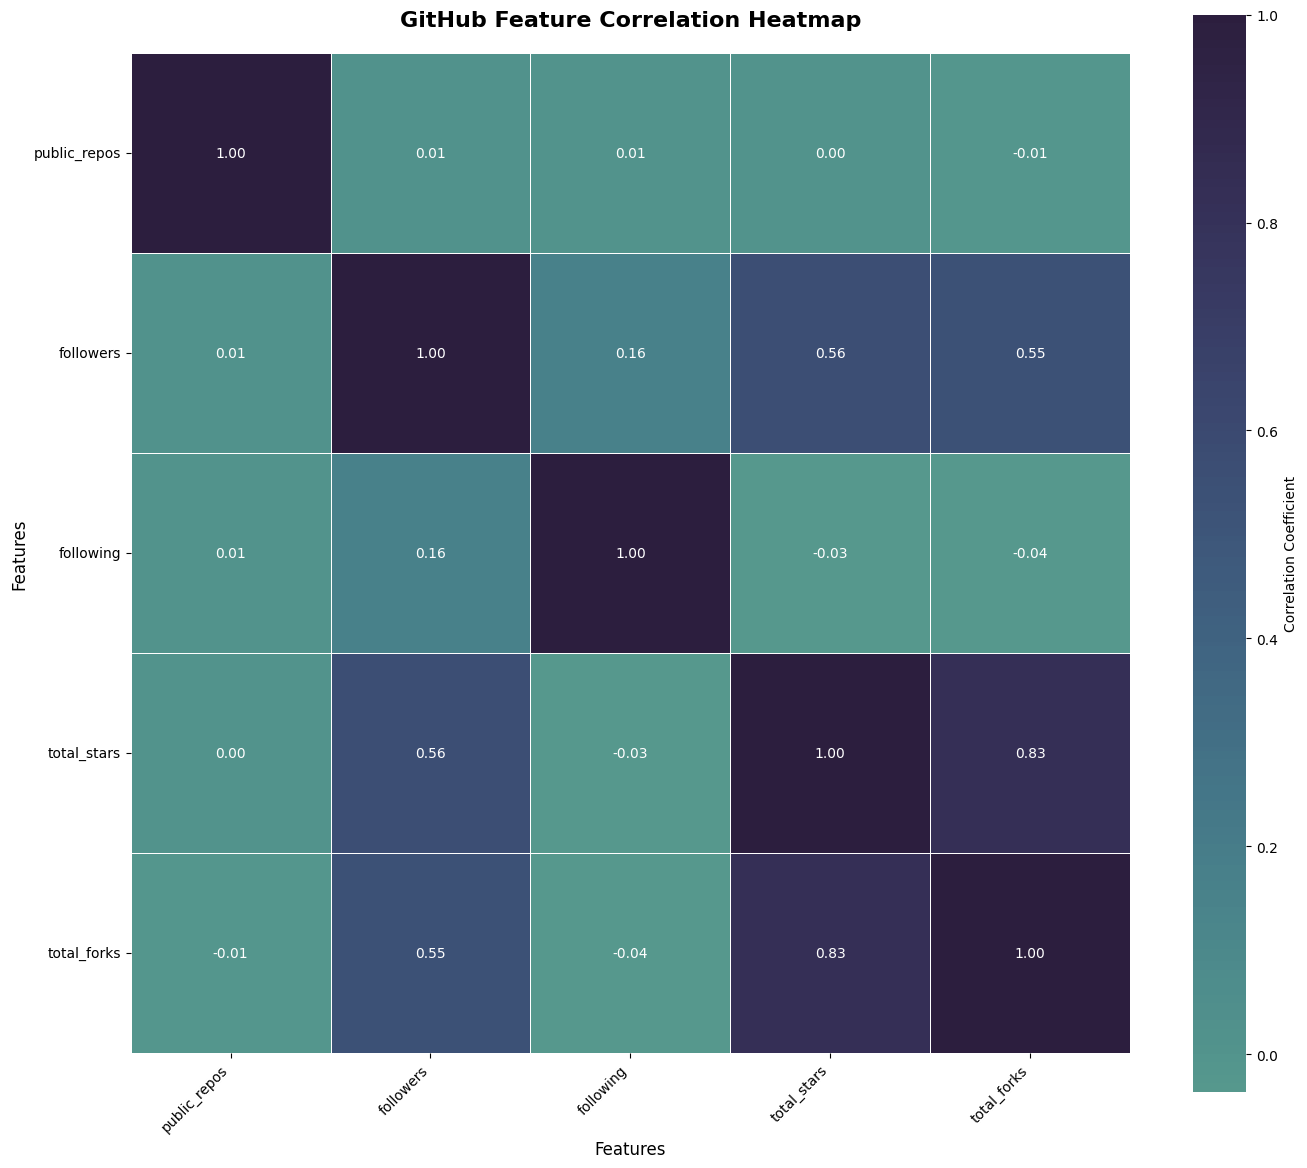

In [6]:
X_with_target = X.copy()

correlation_matrix = X_with_target.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(
    correlation_matrix, 
    annot=True,
    fmt='.2f',
    cmap=sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True),
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('GitHub Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('../ML_Visualizations/github/github_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Scaling

In [7]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X_scaled)

[[-0.11315936 -0.20888666 -0.10156294 -0.36619209 -0.37738567]
 [ 0.02307397 -0.64131522 -0.09535192 -0.39080148 -0.42760697]
 [-0.11094418 -0.01582418 -0.10599938 -0.38450866 -0.39598615]
 ...
 [-0.04781166 -0.49612596 -0.09801379 -0.30955679 -0.21742155]
 [-0.12977318 -0.60050527 -0.06607143 -0.38922827 -0.43225709]
 [-0.08436207 -0.61306218  0.11626621 -0.37203541 -0.40249632]]


# Unsupervised Learning

## K-Means Clustering

Testing different numbers of clusters...


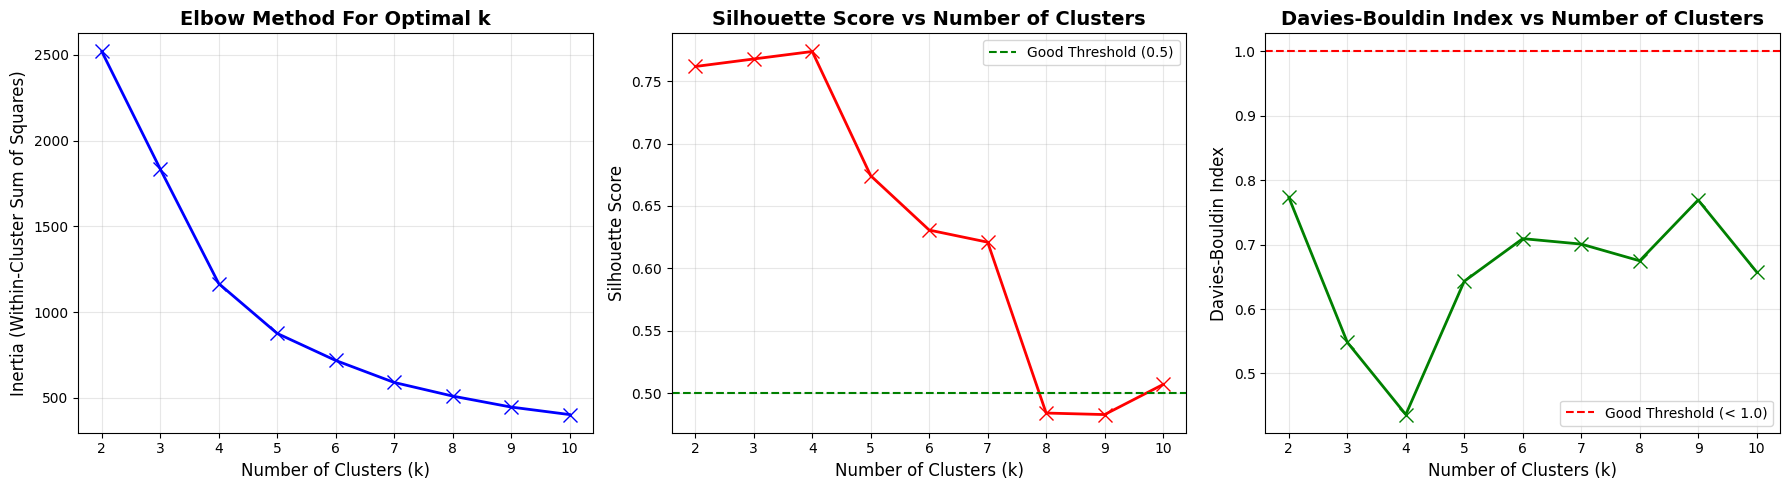


 Optimal number of clusters based on Silhouette Score: 4
   Silhouette Score: 0.774
   Davies-Bouldin Index: 0.436


In [8]:
# Elbow Method to find optimal clusters
print("Testing different numbers of clusters...")
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(X_scaled)
    inertias.append(kmeans_temp.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans_temp.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, kmeans_temp.labels_))

# Plot Elbow + Silhouette + Davies-Bouldin
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Elbow Plot
ax1.plot(K_range, inertias, 'bx-', linewidth=2, markersize=10)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
ax1.set_title('Elbow Method For Optimal k', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Silhouette Score Plot
ax2.plot(K_range, silhouette_scores, 'rx-', linewidth=2, markersize=10)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Score vs Number of Clusters', fontsize=14, fontweight='bold')
ax2.axhline(y=0.5, color='green', linestyle='--', label='Good Threshold (0.5)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Davies-Bouldin Index Plot
ax3.plot(K_range, davies_bouldin_scores, 'gx-', linewidth=2, markersize=10)
ax3.set_xlabel('Number of Clusters (k)', fontsize=12)
ax3.set_ylabel('Davies-Bouldin Index', fontsize=12)
ax3.set_title('Davies-Bouldin Index vs Number of Clusters', fontsize=14, fontweight='bold')
ax3.axhline(y=1.0, color='red', linestyle='--', label='Good Threshold (< 1.0)')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print optimal k based on silhouette score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n Optimal number of clusters based on Silhouette Score: {optimal_k}")
print(f"   Silhouette Score: {max(silhouette_scores):.3f}")
print(f"   Davies-Bouldin Index: {davies_bouldin_scores[optimal_k-2]:.3f}")

CLUSTER QUALITY VALIDATION
Number of Clusters: 2
Silhouette Score: 0.762 (Range: -1 to 1, Higher is Better)
Davies-Bouldin Index: 0.773 (Lower is Better)
GOOD: Clusters are well-separated and cohesive


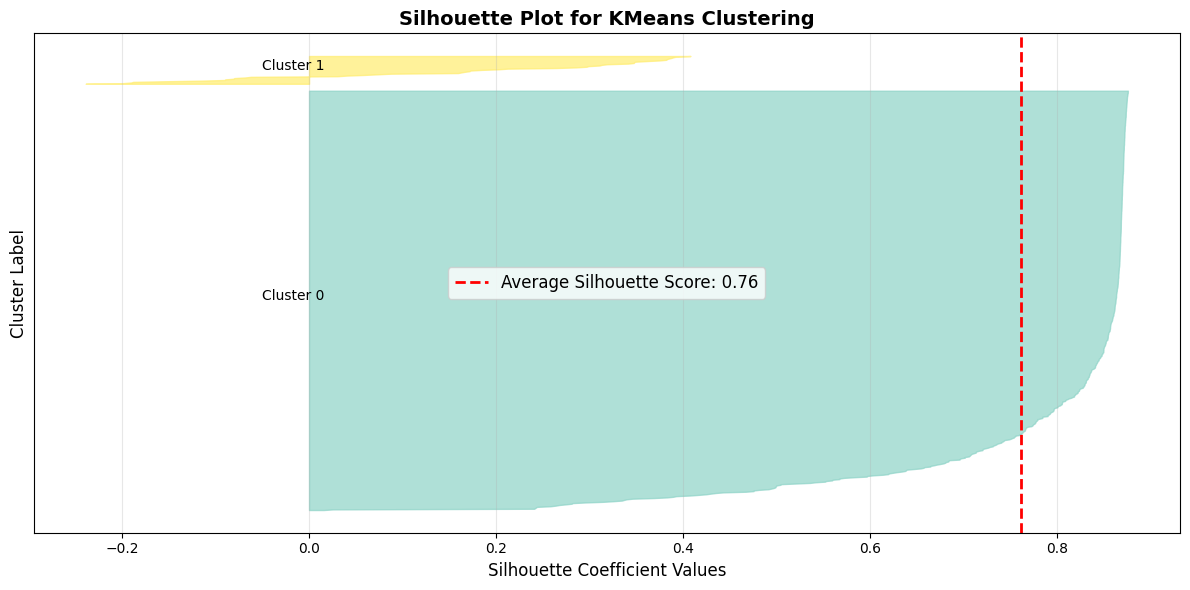


Cluster Distribution:
  Cluster 0: 666 samples (93.7%)
  Cluster 1: 45 samples (6.3%)
Recruiter_Label
Bad     666
Good     45
Name: count, dtype: int64


In [9]:
# Applying K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)  # using random_state = 42 so results stay consistent
df['Cluster_Label'] = kmeans.fit_predict(X_scaled)

# Cluster Quality Metrics
silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
davies_bouldin = davies_bouldin_score(X_scaled, kmeans.labels_)

print("CLUSTER QUALITY VALIDATION")

print(f"Number of Clusters: {kmeans.n_clusters}")
print(f"Silhouette Score: {silhouette_avg:.3f} (Range: -1 to 1, Higher is Better)")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f} (Lower is Better)")

if silhouette_avg > 0.5:
    print("GOOD: Clusters are well-separated and cohesive")
elif silhouette_avg > 0.25:
    print("FAIR: Clusters have some overlap")
else:
    print("POOR: Clusters are not well-defined")

# Silhouette Plot for Visual Validation
fig, ax = plt.subplots(figsize=(12, 6))

silhouette_vals = silhouette_samples(X_scaled, kmeans.labels_)
y_lower = 10

colors = plt.cm.Set3(np.linspace(0, 1, kmeans.n_clusters))

for i in range(kmeans.n_clusters):
    cluster_silhouette_vals = silhouette_vals[kmeans.labels_ == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    # Label the clusters
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}', fontsize=10)
    
    y_lower = y_upper + 10

ax.axvline(x=silhouette_avg, color="red", linestyle="--", linewidth=2,
           label=f'Average Silhouette Score: {silhouette_avg:.2f}')
ax.set_xlabel("Silhouette Coefficient Values", fontsize=12)
ax.set_ylabel("Cluster Label", fontsize=12)
ax.set_title("Silhouette Plot for KMeans Clustering", fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
ax.set_yticks([])
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print cluster distribution
print(f"\nCluster Distribution:")
cluster_counts = pd.Series(kmeans.labels_).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(kmeans.labels_)) * 100
    print(f"  Cluster {cluster_id}: {count} samples ({percentage:.1f}%)")


# Identify which cluster is Good
# K-means doesn't know Good v/s Bad, it knows Group 0 and Group 1
# check which group has the higher average reputation
cluster_0_avg = df[df['Cluster_Label'] == 0]['total_stars'].mean()
cluster_1_avg = df[df['Cluster_Label'] == 1]['total_stars'].mean()

if cluster_1_avg > cluster_0_avg:
    df['Recruiter_Label'] = df['Cluster_Label'].map({1: 'Good', 0: 'Bad'})
else:
    df['Recruiter_Label'] = df['Cluster_Label'].map({0: 'Good', 1: 'Bad'})

print(df['Recruiter_Label'].value_counts())

C:\Users\Anushka\AppData\Local\Temp\ipykernel_17920\328526701.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Recruiter_Label', data=df, palette={'Good': 'green', 'Bad': 'blue'})


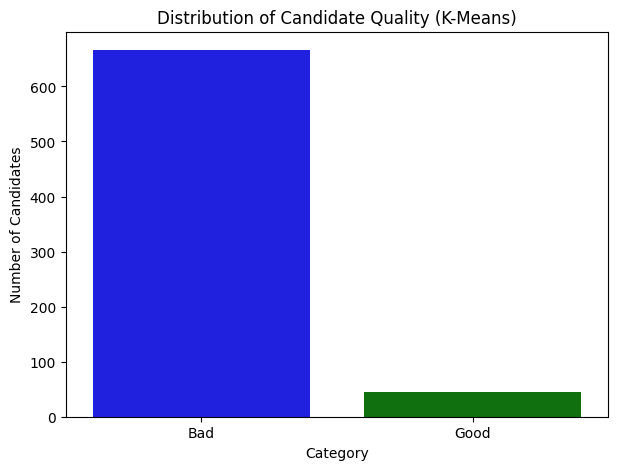

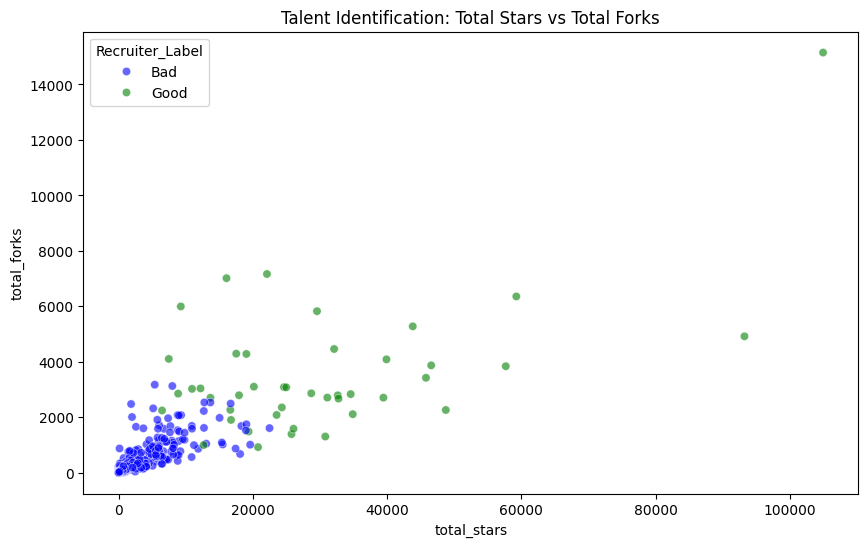

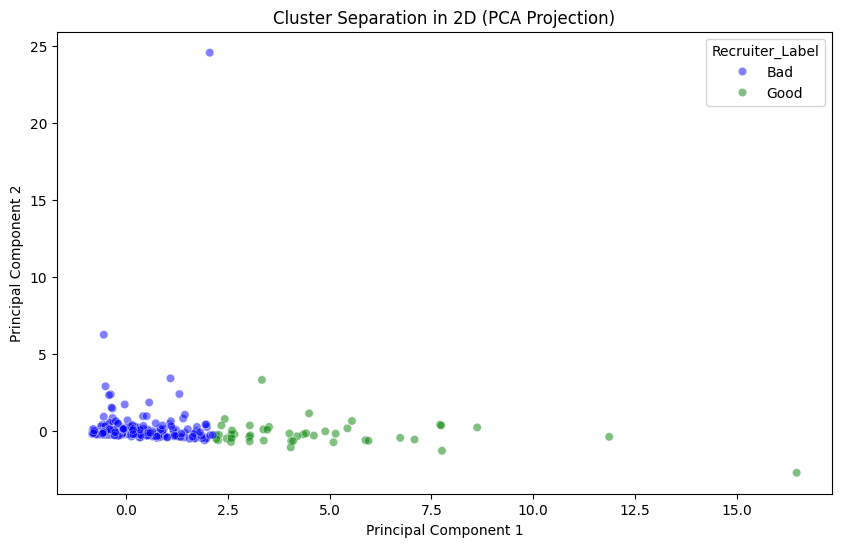

In [10]:
# BAR CHART: Talent Distribution
plt.figure(figsize=(7, 5))
sns.countplot(x='Recruiter_Label', data=df, palette={'Good': 'green', 'Bad': 'blue'})
plt.title('Distribution of Candidate Quality (K-Means)')
plt.ylabel('Number of Candidates')
plt.xlabel('Category')
plt.savefig('../ML_Visualizations/github/github_distribution_counts.png')

# SCATTER PLOT : Total Stars vs Total Forks
# This shows how the 'Good' group is physically separated in the data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='total_stars', y='total_forks', hue='Recruiter_Label',
                palette={'Good': 'green', 'Bad': 'blue'}, alpha=0.6)
plt.title('Talent Identification: Total Stars vs Total Forks')
plt.savefig('../ML_Visualizations/github/github_feature_scatter.png')

# PCA PLOT
# This shows how the AI "sees" the clusters using all 4 features at once
pca = PCA(n_components=2)
coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=coords[:, 0], y=coords[:, 1], hue=df['Recruiter_Label'],
                palette={'Good': 'green', 'Bad': 'blue'}, alpha=0.5)
plt.title('Cluster Separation in 2D (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.savefig('../ML_Visualizations/github/github_pca_cluster_viz.png')

## Train - Test Split

In [11]:
# PREPARE DATA
X = df[feature_columns]
y = df['Cluster_Label']

# TRAIN/TEST SPLIT
# We split first so the test set remains pure real data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True)

## SMOTE

In [12]:
# APPLY SMOTE (TO TRAINING ONLY)
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

C:\Users\Anushka\AppData\Local\Temp\ipykernel_17920\1828385421.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Bad (0)', 'Good (1)'], y=before_counts.values, ax=ax[0], palette='Blues')
C:\Users\Anushka\AppData\Local\Temp\ipykernel_17920\1828385421.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Bad (0)', 'Good (1)'], y=after_counts.values, ax=ax[1], palette='crest')


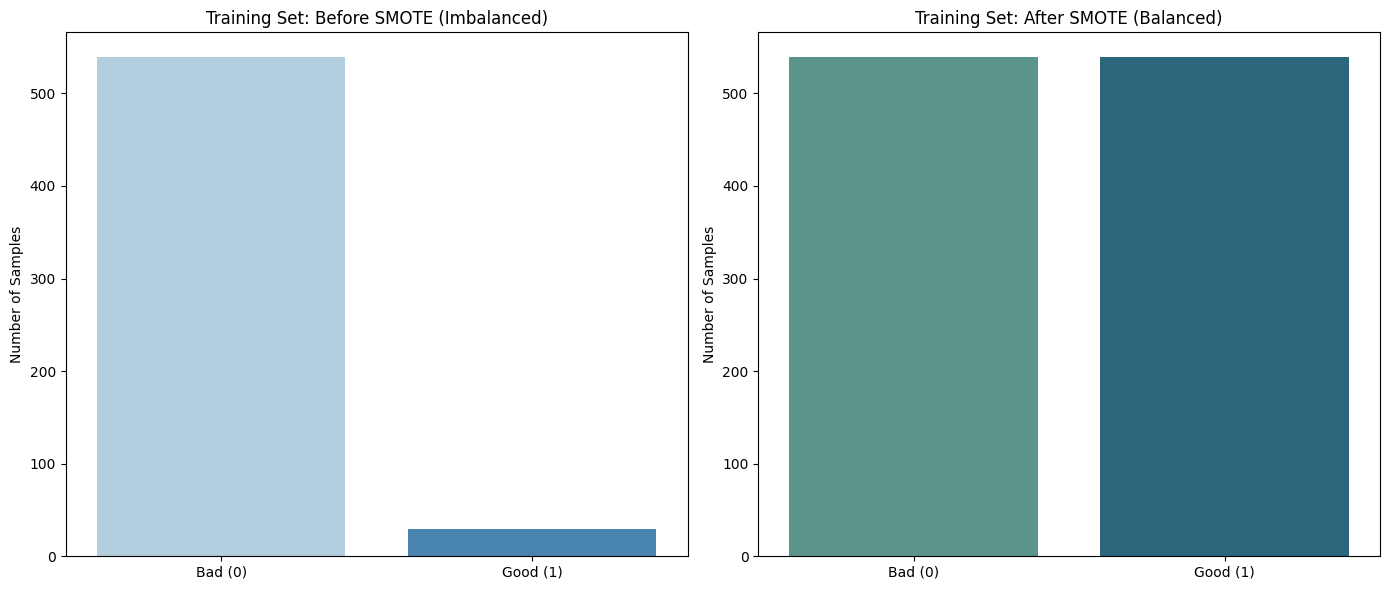

In [13]:
# Visualization plot to show the effect of SMOTE on the training data distribution
before_counts = pd.Series(y_train).value_counts().sort_index()
after_counts = pd.Series(y_train_res).value_counts().sort_index()

# Set up the plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Plot Before SMOTE
sns.barplot(x=['Bad (0)', 'Good (1)'], y=before_counts.values, ax=ax[0], palette='Blues')
ax[0].set_title('Training Set: Before SMOTE (Imbalanced)')
ax[0].set_ylabel('Number of Samples')

# Plot After SMOTE
sns.barplot(x=['Bad (0)', 'Good (1)'], y=after_counts.values, ax=ax[1], palette='crest')
ax[1].set_title('Training Set: After SMOTE (Balanced)')
ax[1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

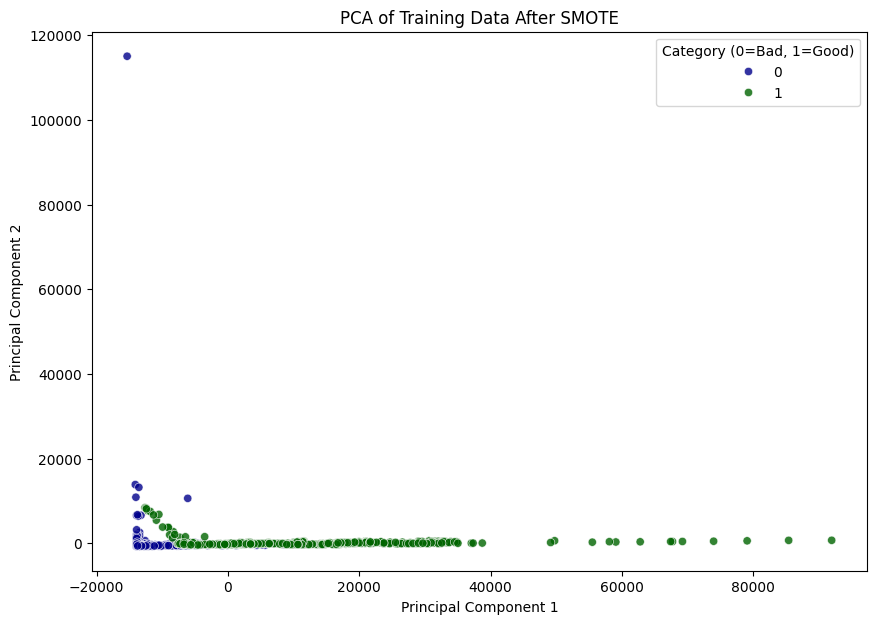

In [14]:
# Use PCA to flatten the resampled data into 2D
pca = PCA(n_components=2)
X_pca_res = pca.fit_transform(X_train_res)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca_res[:, 0], y=X_pca_res[:, 1], hue=y_train_res,
                palette={1: 'darkgreen', 0: 'darkblue'}, alpha=0.8)
plt.title('PCA of Training Data After SMOTE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Category (0=Bad, 1=Good)')
plt.show()

# Supervised Learning

## Random Forest

Final Model Performance
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       127
           1       1.00      0.69      0.81        16

    accuracy                           0.97       143
   macro avg       0.98      0.84      0.90       143
weighted avg       0.97      0.97      0.96       143



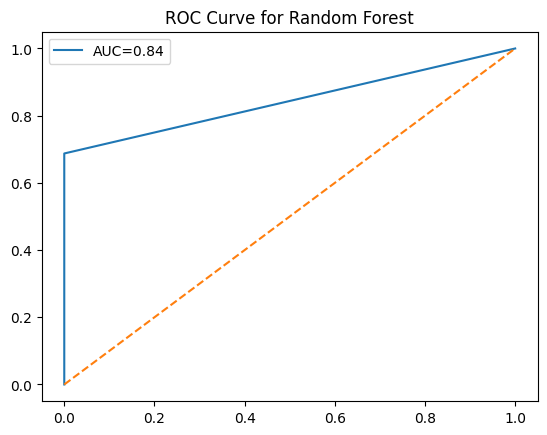


 TOP 10 CANDIDATE PICKS
         username  total_stars  Selection_Probability
944       matryer        31108                    1.0
879            rs        32774                    1.0
854     mikeroyal        45801                    1.0
906        samber        39459                    1.0
802        muesli        34894                    1.0
778     Terry-Mao        12215                    1.0
719      appleboy        24982                    1.0
611       tidwall        57689                    1.0
53          mholt        32660                    1.0
644  GoesToEleven        16086                    1.0


In [15]:
# Initialize the Random Forest
# n_estimators = 100 means we are using 100 individual decision trees
rf_model = RandomForestClassifier(n_estimators=100, random_state= 42)

# Training the model using SMOTE balanced training data
rf_model.fit(X_train_res, y_train_res)


y_pred_rf = rf_model.predict(X_test)
print("Final Model Performance")
print(classification_report(y_test, y_pred_rf))

# ROC Curve for Random Forest
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)

plt.title("ROC Curve for Random Forest")
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.2f}")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

# RANKING: Use the model to find the Top 10 Picks
# Get the probability of being Good (1 class)
all_features = df[['public_repos', 'followers', 'following', 'total_stars', 'total_forks']]
df['Selection_Probability'] = rf_model.predict_proba(all_features)[:, 1]

# Sort by probability, then by Reputation
top_10_candidates = df.sort_values(by=['Selection_Probability'], ascending=False).head(10)

print("\n TOP 10 CANDIDATE PICKS")
print(top_10_candidates[['username', 'total_stars', 'Selection_Probability']])

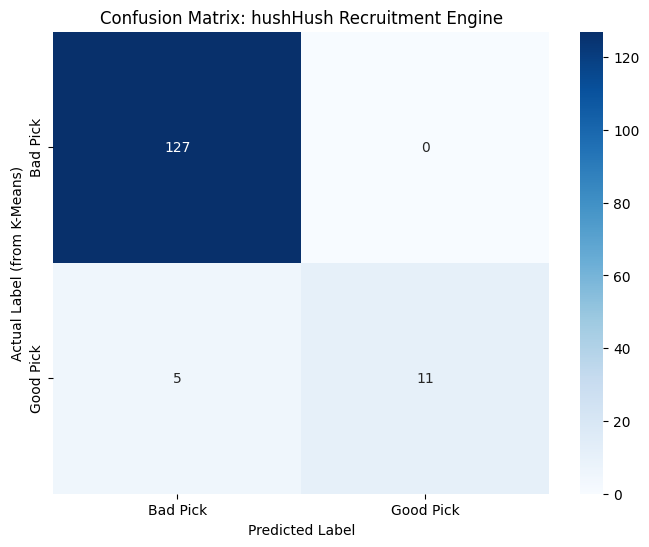

In [16]:
# Generate the matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Visualize it
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad Pick', 'Good Pick'],
            yticklabels=['Bad Pick', 'Good Pick'])
plt.title('Confusion Matrix: hushHush Recruitment Engine')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label (from K-Means)')
plt.show()

## Decision Tree

Decision Tree Model Performance
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       127
           1       1.00      0.75      0.86        16

    accuracy                           0.97       143
   macro avg       0.98      0.88      0.92       143
weighted avg       0.97      0.97      0.97       143



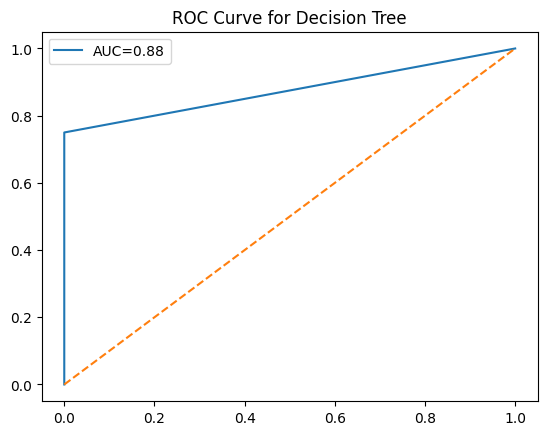

Decision Tree - TOP 10 CANDIDATE PICKS
        username  total_stars  Selection_Probability_DT
72   FiloSottile        93244                       1.0
191    linexjlin        32117                       1.0
53         mholt        32660                       1.0
439    saadpasta         7490                       1.0
119        xtaci        29569                       1.0
206     feiskyer        10950                       1.0
338       zserge        24331                       1.0
183    smallnest        16652                       1.0
123   alecthomas        23553                       1.0
198       ahmetb        43834                       1.0


In [17]:
# Initialize the Decision Tree
# max_depth limits how deep the tree can grow to prevent overfitting
dt_model = DecisionTreeClassifier(max_depth=10, random_state= 42)

# Training the model using SMOTE balanced training data
dt_model.fit(X_train_res, y_train_res)

# Evaluate on Real World unbalanced test set
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Model Performance")
print(classification_report(y_test, y_pred_dt))

# ROC Curve for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

plt.title("ROC Curve for Decision Tree")
plt.plot(fpr_dt, tpr_dt, label=f"AUC={roc_auc_dt:.2f}")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

# RANKING: Use the model to find the Top 10 Picks
# Get the probability of being Good (1 class)
all_features = df[['public_repos', 'followers', 'following', 'total_stars', 'total_forks']]
df['Selection_Probability_DT'] = dt_model.predict_proba(all_features)[:, 1]

# Sort by probability, then by Stars
top_10_candidates_dt = df.sort_values(by=['Selection_Probability_DT'], ascending=False).head(10)

print("Decision Tree - TOP 10 CANDIDATE PICKS")
print(top_10_candidates_dt[['username', 'total_stars', 'Selection_Probability_DT']])

## XG Boost

XGBoost Model Performance
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       127
           1       1.00      0.56      0.72        16

    accuracy                           0.95       143
   macro avg       0.97      0.78      0.85       143
weighted avg       0.95      0.95      0.94       143



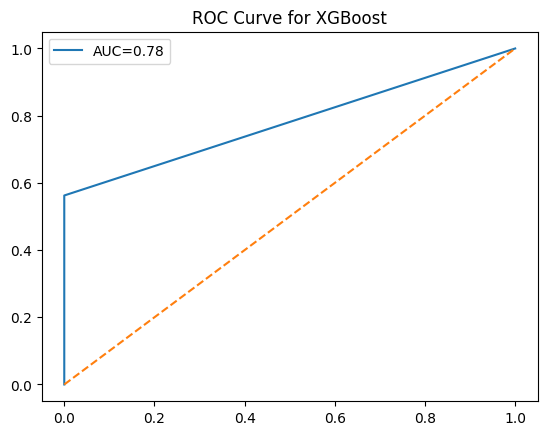

XGBoost - TOP 10 CANDIDATE PICKS
        username  total_stars  Selection_Probability_XGB
944      matryer        31108                   0.999886
72   FiloSottile        93244                   0.999886
719     appleboy        24982                   0.999866
198       ahmetb        43834                   0.999866
879           rs        32774                   0.999847
802       muesli        34894                   0.999843
659      schollz        48757                   0.999843
119        xtaci        29569                   0.999843
12         fatih        39916                   0.999843
611      tidwall        57689                   0.999820


In [18]:
# Initialize the XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, eval_metric='logloss', random_state= 42)

# Training the model using SMOTE balanced training data
xgb_model.fit(X_train_res, y_train_res)

# Evaluate on Real World unbalanced test set
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Model Performance")
print(classification_report(y_test, y_pred_xgb))

# ROC Curve for XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

plt.title("ROC Curve for XGBoost")
plt.plot(fpr_xgb, tpr_xgb, label=f"AUC={roc_auc_xgb:.2f}")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.show()

# RANKING: Use the model to find the Top 10 Picks
# Get the probability of being Good (1 class)
all_features = df[['public_repos', 'followers', 'following', 'total_stars', 'total_forks']]
df['Selection_Probability_XGB'] = xgb_model.predict_proba(all_features)[:, 1]

# Sort by probability, then by Stars
top_10_candidates_xgb = df.sort_values(by=['Selection_Probability_XGB'], ascending=False).head(10)


print("XGBoost - TOP 10 CANDIDATE PICKS")
print(top_10_candidates_xgb[['username', 'total_stars', 'Selection_Probability_XGB']])

## Model Summary

MODEL PERFORMANCE COMPARISON

Random Forest:
  Accuracy:  0.965
  Precision: 1.000
  Recall:    0.688
  F1-Score:  0.815

Decision Tree:
  Accuracy:  0.972
  Precision: 1.000
  Recall:    0.750
  F1-Score:  0.857

XGBoost:
  Accuracy:  0.951
  Precision: 1.000
  Recall:    0.562
  F1-Score:  0.720
BEST MODEL: Decision Tree (F1-Score: 0.857)

Model Comparison Table:
        Model  Accuracy  Precision  Recall  F1-Score
Random Forest  0.965035        1.0  0.6875  0.814815
Decision Tree  0.972028        1.0  0.7500  0.857143
      XGBoost  0.951049        1.0  0.5625  0.720000


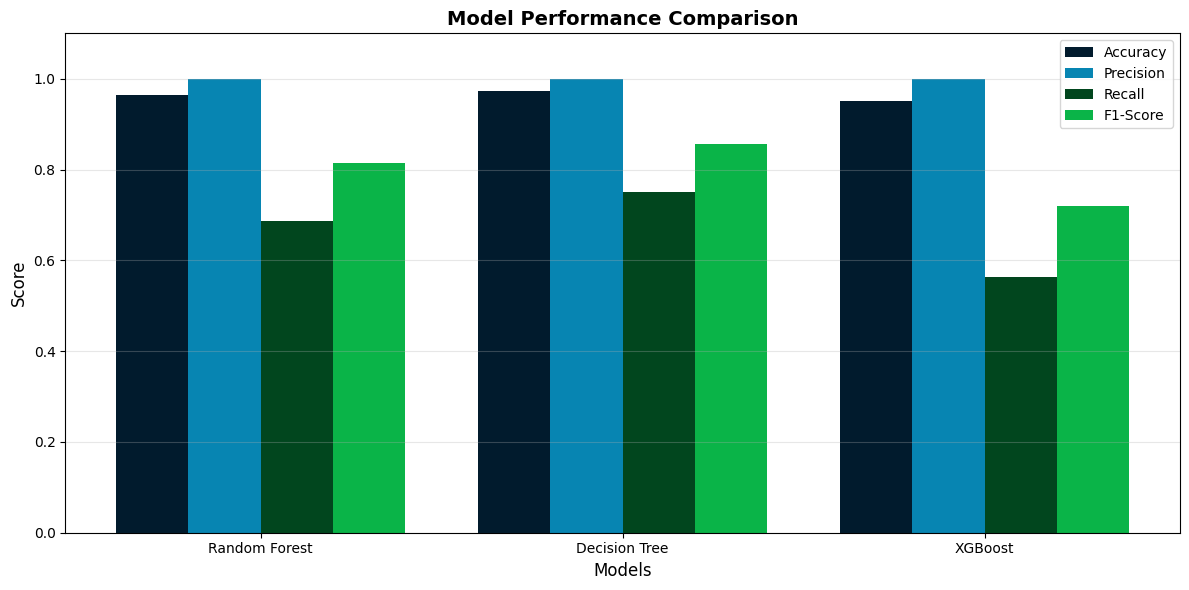


Using Decision Tree for final predictions


'\nprint("CROSS-VALIDATION RESULTS")\n\nfor name, model in models.items():\n    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring=\'f1\')\n    print(f"\n{name}:")\n    print(f"  CV F1 Scores: {cv_scores}")\n    print(f"  Mean CV F1:   {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")\n    '

In [19]:
print("MODEL PERFORMANCE COMPARISON")

models = {
    'Random Forest': rf_model,
    'Decision Tree': dt_model,
    'XGBoost': xgb_model
}

# Store results
results = []
best_model_name = None
best_f1 = 0

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {acc:.3f}")
    print(f"  Precision: {prec:.3f}")
    print(f"  Recall:    {rec:.3f}")
    print(f"  F1-Score:  {f1:.3f}")
    
    if f1 > best_f1:
        best_f1 = f1
        best_model_name = name

print(f"BEST MODEL: {best_model_name} (F1-Score: {best_f1:.3f})")

# Create comparison DataFrame
comparison_df = pd.DataFrame(results)
print("\nModel Comparison Table:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results))
width = 0.2

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ["#011b2d", "#0785B2", "#01461e", "#0ab448"]

for i, metric in enumerate(metrics):
    values = [r[metric] for r in results]
    ax.bar(x + i*width, values, width, label=metric, color=colors[i])

ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels([r['Model'] for r in results])
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.show()

# Use best model for final predictions
final_model = models[best_model_name]
print(f"\nUsing {best_model_name} for final predictions")

"""
print("CROSS-VALIDATION RESULTS")

for name, model in models.items():
    cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1')
    print(f"\n{name}:")
    print(f"  CV F1 Scores: {cv_scores}")
    print(f"  Mean CV F1:   {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    """

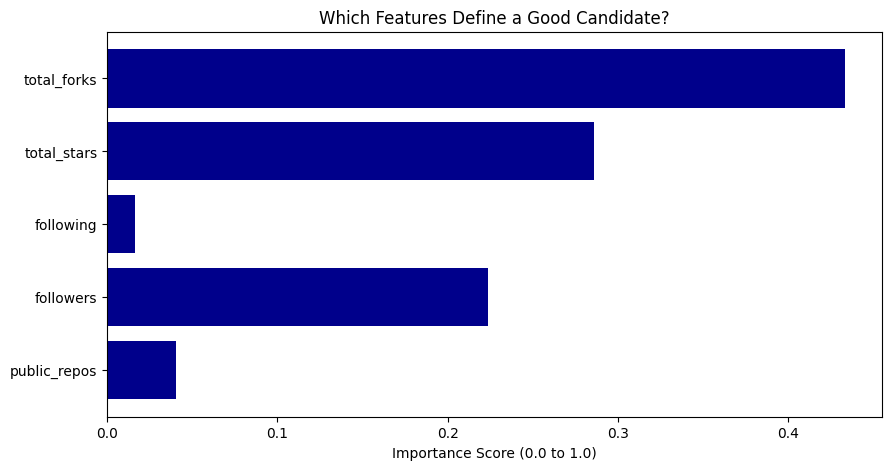

In [20]:
# Get importance scores
importances = rf_model.feature_importances_

plt.figure(figsize=(10, 5))
plt.barh(feature_columns, importances, color='darkblue')
plt.title('Which Features Define a Good Candidate?')
plt.xlabel('Importance Score (0.0 to 1.0)')
plt.show()

In [21]:
# Save model and scaler to pickle file
with open('github_model.pkl', 'wb') as f:
    pickle.dump({'model': final_model, 'scaler': scaler}, f)

print("Model saved!")

Model saved!


# Export to CSV

In [22]:
# Recalculate predictions using the best model
df['Selection_Probability'] = final_model.predict_proba(X)[:, 1]

# Sort by probability and get top 10
top_10_candidates = df.sort_values(by=['Selection_Probability'], ascending=False).head(10)

print("\n TOP 10 CANDIDATE PICKS")
print(top_10_candidates[['username', 'total_stars', 'Selection_Probability']])
top_10_candidates.to_csv('../Shortlisted_candidates/github_shortlisted_candidates.csv', index=False)


 TOP 10 CANDIDATE PICKS
        username  total_stars  Selection_Probability
72   FiloSottile        93244                    1.0
191    linexjlin        32117                    1.0
53         mholt        32660                    1.0
439    saadpasta         7490                    1.0
119        xtaci        29569                    1.0
206     feiskyer        10950                    1.0
338       zserge        24331                    1.0
183    smallnest        16652                    1.0
123   alecthomas        23553                    1.0
198       ahmetb        43834                    1.0
